In [1]:
!pip3 install datasets
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")

# Exploring the structure of the dataset
print(dataset)

# Access the first example from the training split
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})
{'tokens': ['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.'], 'pos_tags': ['ADP', 'DET', 'NOUN', 'DET', 'PROPN', 'PROPN', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'AUX', 'VERB', 'PUNCT'], 'ner_tags': ['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']}


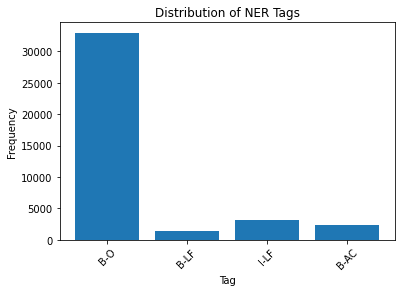

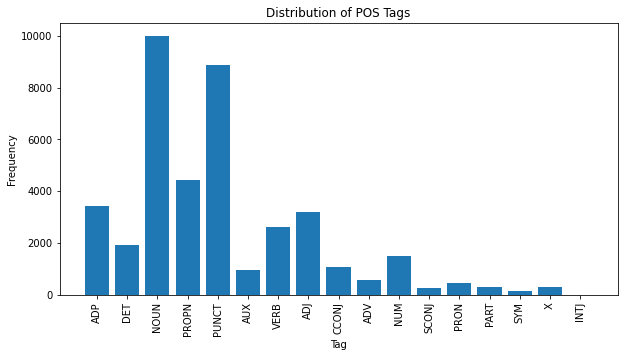

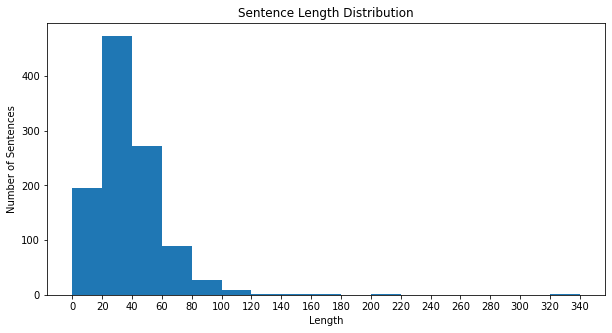

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Name loaded dataset
train_sentences = dataset['train']['tokens']
train_ner_tags = dataset['train']['ner_tags']
train_pos_tags = dataset['train']['pos_tags']

# Flatten lists to count labels
flat_ner_tags = [tag for sublist in train_ner_tags for tag in sublist]
flat_pos_tags = [tag for sublist in train_pos_tags for tag in sublist]

# Count each label occurrence
ner_labels_count = Counter(flat_ner_tags)
pos_labels_count = Counter(flat_pos_tags)

# Plotting for NER tags
plt.bar(ner_labels_count.keys(), ner_labels_count.values())
plt.title('Distribution of NER Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plotting for POS tags
plt.figure(figsize=(10, 5))  # Increase figure size for better visibility
plt.bar(pos_labels_count.keys(), pos_labels_count.values())  # Use a different color for distinction
plt.title('Distribution of POS Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
plt.show()

# Sentence lengths
plt.figure(figsize=(10, 5))
sentence_lengths = [len(sentence) for sentence in train_sentences]
# Define bin edges
bin_edges = [i for i in range(0, max(sentence_lengths) + 20, 20)]
plt.hist(sentence_lengths, bins=bin_edges)
plt.xticks(bin_edges)
plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.show()

In [4]:
train_data = dataset['train']
test_data = dataset['test']
validation_data = dataset['validation']

from collections import Counter

# Count ner tags in each datasets
def count_ner_tags(dataset_split):
    ner_tags_counter = Counter()
    for item in dataset_split:
        ner_tags_counter.update(item['ner_tags'])
    return dict(ner_tags_counter)

# Apply the function to each dataset split
train_ner_counts = count_ner_tags(train_data)
test_ner_counts = count_ner_tags(test_data)
validation_ner_counts = count_ner_tags(validation_data)

# Define a consistent order for all outputs
sorted_tags = ['B-O', 'B-AC', 'B-LF', 'I-LF'] 
print({tag: train_ner_counts.get(tag, 0) for tag in sorted_tags})
print({tag: test_ner_counts.get(tag, 0) for tag in sorted_tags})
print({tag: validation_ner_counts.get(tag, 0) for tag in sorted_tags})

{'B-O': 32971, 'B-AC': 2336, 'B-LF': 1462, 'I-LF': 3231}
{'B-O': 4292, 'B-AC': 270, 'B-LF': 150, 'I-LF': 288}
{'B-O': 4261, 'B-AC': 263, 'B-LF': 149, 'I-LF': 327}


In [5]:
# Calculate the length of the tokens for each entry and display statistics
train_df = dataset['train'].to_pandas()
train_df['sentence_length'] = train_df['tokens'].apply(len)
print(train_df['sentence_length'].describe())

count    1072.000000
mean       37.313433
std        22.985699
min         2.000000
25%        23.000000
50%        33.000000
75%        48.000000
max       323.000000
Name: sentence_length, dtype: float64


# Experiment 1: CRF with different Data Pre-processing Techniques

In [6]:
!pip install sklearn_crfsuite

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import nltk
from nltk.corpus import stopwords
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Download and setup stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset['train']
test_data = dataset['test']

# Define preprocessing functions
def preprocess_no_change(tokens):
    return tokens
    
# Change words into lowercase
def preprocess_to_lowercase(tokens):
    return [token.lower() for token in tokens]

# Lowercasing + Remove stop words
def preprocess_remove_stopwords(tokens):
    return [token.lower() for token in tokens if token.lower() not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     /user/HS400/ch01402/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Feature extraction and label extraction functions
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(), # Provide the CRF model with a lowercase format
        'word[-3:]': word[-3:], # Last three characters
        'word[-2:]': word[-2:], # Last two characters
        'word.isupper()': word.isupper(), # Is the word uppercase
        'word.istitle()': word.istitle(), # Is the word a title
        'word.isdigit()': word.isdigit(), # Is the word a number
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True # Beginning of sentence

    if i < len(sent) - 1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True # End of sentence
    return features

def extract_features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def extract_labels(sent):
    return [label for token, label in sent]

In [9]:
# No preprocessing
train_sentences = [preprocess_no_change(sentence) for sentence in train_data['tokens']]

# Apply the chosen preprocessing function to the test data
test_sentences = [preprocess_no_change(sentence) for sentence in test_data['tokens']] 

# Each sentence is transformed into a list of (token, tag) tuples.
train_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(train_sentences, train_data['ner_tags'])
]

# Prepare the test data for CRF
test_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(test_sentences, test_data['ner_tags'])
]

# X contain extracted features for each token in each sentence of the training and test datasets.
# Y contain the corresponding NER tags for each token.
# These variables are used to train the CRF model and evaluate its performance on unseen data.
X_train = [extract_features(s) for s in train_sents]
y_train = [extract_labels(s) for s in train_sents]

# Extract features and labels from the test data
X_test = [extract_features(s) for s in test_sents]
y_test = [extract_labels(s) for s in test_sents]

# Extract unique labels from the training data for reporting
unique_labels = sorted(set([label for sublist in y_train for label in sublist]))

# Now continue with the CRF training and evaluation using the test data
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.1, max_iterations=200, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Predict using the trained CRF model on the test data
y_pred_test = crf.predict(X_test)

# Calculate F1 Score and report for the test data
f1_score_test1 = metrics.flat_f1_score(y_test, y_pred_test, average='weighted')
print("F1 Score on Test Data:", f1_score_test1)

# Generate classification report for the test data
y_true_flat_test = [label for sublist in y_test for label in sublist]
y_pred_flat_test = [label for sublist in y_pred_test for label in sublist]
report_test = classification_report(y_true_flat_test, y_pred_flat_test, labels=unique_labels, digits=3)
print("Classification Report on Test Data:\n", report_test)

F1 Score on Test Data: 0.9084631043778376
Classification Report on Test Data:
               precision    recall  f1-score   support

        B-AC      0.796     0.637     0.708       270
        B-LF      0.612     0.493     0.546       150
         B-O      0.942     0.962     0.951      4292
        I-LF      0.654     0.635     0.644       288

    accuracy                          0.911      5000
   macro avg      0.751     0.682     0.712      5000
weighted avg      0.907     0.911     0.908      5000



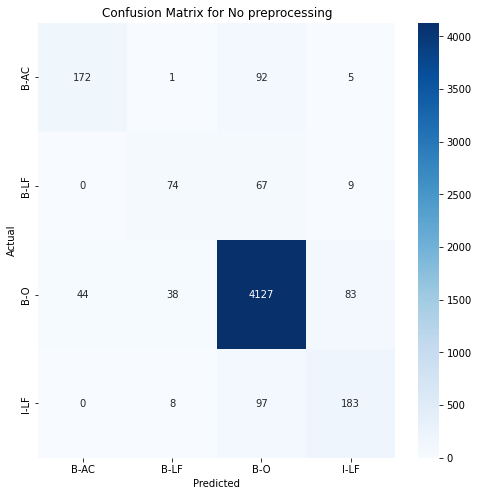

In [10]:
# Confusion Matrix for test data
conf_mat_test = confusion_matrix(y_true_flat_test, y_pred_flat_test, labels=unique_labels)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for No preprocessing')
plt.show()

In [11]:
# Using lowercase function to apply
train_sentences = [preprocess_to_lowercase(sentence) for sentence in train_data['tokens']] 

# Apply the chosen preprocessing function to the test data
test_sentences = [preprocess_to_lowercase(sentence) for sentence in test_data['tokens']] 


train_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(train_sentences, train_data['ner_tags'])
]

# Prepare the test data for CRF
test_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(test_sentences, test_data['ner_tags'])
]

X_train = [extract_features(s) for s in train_sents]
y_train = [extract_labels(s) for s in train_sents]

# Extract features and labels from the test data
X_test = [extract_features(s) for s in test_sents]
y_test = [extract_labels(s) for s in test_sents]

# Extract unique labels from the training data for reporting
unique_labels = sorted(set([label for sublist in y_train for label in sublist]))

# Now continue with the CRF training and evaluation using the test data
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.1, max_iterations=200, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Predict using the trained CRF model on the test data
y_pred_test = crf.predict(X_test)

# Calculate F1 Score and report for the test data
f1_score_test2 = metrics.flat_f1_score(y_test, y_pred_test, average='weighted')
print("F1 Score on Test Data:", f1_score_test2)

# Generate classification report for the test data
y_true_flat_test = [label for sublist in y_test for label in sublist]
y_pred_flat_test = [label for sublist in y_pred_test for label in sublist]
report_test = classification_report(y_true_flat_test, y_pred_flat_test, labels=unique_labels, digits=3)
print("Classification Report on Test Data:\n", report_test)

F1 Score on Test Data: 0.8944489392956743
Classification Report on Test Data:
               precision    recall  f1-score   support

        B-AC      0.730     0.530     0.614       270
        B-LF      0.568     0.447     0.500       150
         B-O      0.932     0.959     0.945      4292
        I-LF      0.631     0.587     0.608       288

    accuracy                          0.899      5000
   macro avg      0.715     0.631     0.667      5000
weighted avg      0.892     0.899     0.894      5000



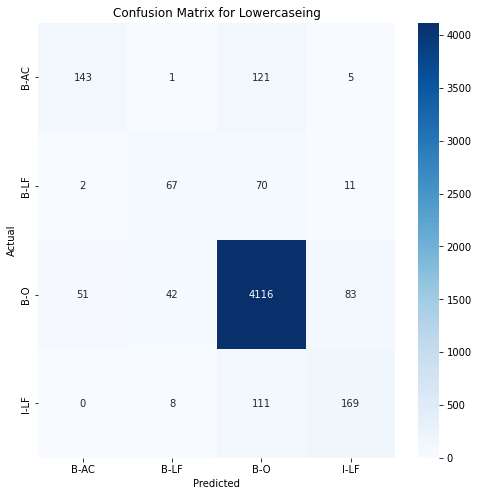

In [12]:
# Confusion Matrix for test data
conf_mat_test = confusion_matrix(y_true_flat_test, y_pred_flat_test, labels=unique_labels)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Lowercaseing')
plt.show()

In [13]:
# Remove stop-words function to apply
train_sentences = [preprocess_remove_stopwords(sentence) for sentence in train_data['tokens']]

# Apply the chosen preprocessing function to the test data
test_sentences = [preprocess_remove_stopwords(sentence) for sentence in test_data['tokens']]  


train_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(train_sentences, train_data['ner_tags'])
]

# Prepare the test data for CRF
test_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(test_sentences, test_data['ner_tags'])
]

X_train = [extract_features(s) for s in train_sents]
y_train = [extract_labels(s) for s in train_sents]

# Extract features and labels from the test data
X_test = [extract_features(s) for s in test_sents]
y_test = [extract_labels(s) for s in test_sents]

# Extract unique labels from the training data for reporting
unique_labels = sorted(set([label for sublist in y_train for label in sublist]))

# Now continue with the CRF training and evaluation using the test data
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.1, max_iterations=200, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Predict using the trained CRF model on the test data
y_pred_test = crf.predict(X_test)

# Calculate F1 Score and report for the test data
f1_score_test3 = metrics.flat_f1_score(y_test, y_pred_test, average='weighted')
print("F1 Score on Test Data:", f1_score_test3)

# Generate classification report for the test data
y_true_flat_test = [label for sublist in y_test for label in sublist]
y_pred_flat_test = [label for sublist in y_pred_test for label in sublist]
report_test = classification_report(y_true_flat_test, y_pred_flat_test, labels=unique_labels, digits=3)
print("Classification Report on Test Data:\n", report_test)

F1 Score on Test Data: 0.7771453326071985
Classification Report on Test Data:
               precision    recall  f1-score   support

        B-AC      0.278     0.069     0.111       216
        B-LF      0.132     0.038     0.059       132
         B-O      0.852     0.960     0.903      3248
        I-LF      0.186     0.072     0.103       251

    accuracy                          0.820      3847
   macro avg      0.362     0.285     0.294      3847
weighted avg      0.752     0.820     0.777      3847



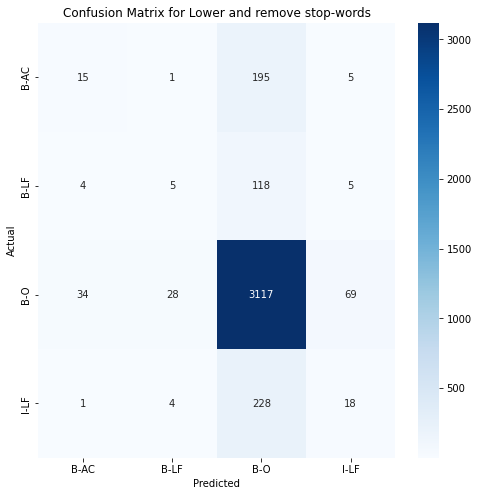

In [14]:
# Confusion Matrix for test data
conf_mat_test = confusion_matrix(y_true_flat_test, y_pred_flat_test, labels=unique_labels)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Lower and remove stop-words')
plt.show()

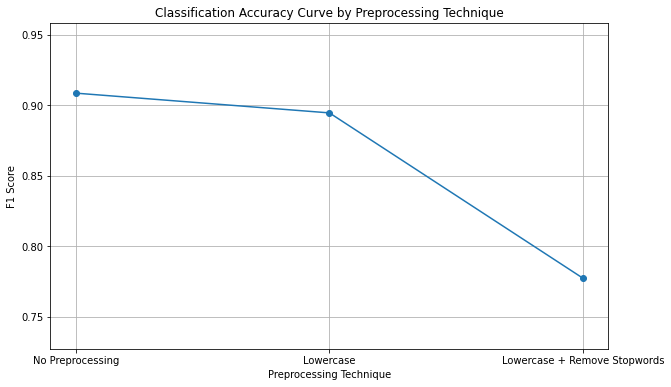

In [15]:
preprocessing_labels = ['No Preprocessing', 'Lowercase', 'Lowercase + Remove Stopwords']
f1_scores = [f1_score_test1, f1_score_test2, f1_score_test3]

# Plotting Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(preprocessing_labels, f1_scores, marker='o')
plt.title('Classification Accuracy Curve by Preprocessing Technique')
plt.xlabel('Preprocessing Technique')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(preprocessing_labels)
plt.ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])
plt.show()

# Experiment 2: Compare CRF with SVM

In [16]:
# No preprocessing perforce the best from before
train_sentences = [preprocess_no_change(sentence) for sentence in train_data['tokens']]

# Apply the chosen preprocessing function to the test data
test_sentences = [preprocess_no_change(sentence) for sentence in test_data['tokens']] 

# Each sentence is transformed into a list of (token, tag) tuples.
train_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(train_sentences, train_data['ner_tags'])
]

# Prepare the test data for SVM
test_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(test_sentences, test_data['ner_tags'])
]

# X contain extracted features for each token in each sentence of the training and test datasets.
# Y contain the corresponding NER tags for each token.
# These variables are used to train the CRF model and evaluate its performance on unseen data.
X_train = [extract_features(s) for s in train_sents]
y_train = [extract_labels(s) for s in train_sents]

# Extract features and labels from the test data
X_test = [extract_features(s) for s in test_sents]
y_test = [extract_labels(s) for s in test_sents]

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score

# Step 2: Convert feature dicts to vectors
dict_vectorizer = DictVectorizer(sparse=True)
X_train_vect = dict_vectorizer.fit_transform([feat for sent in X_train for feat in sent])
X_test_vect = dict_vectorizer.transform([feat for sent in X_test for feat in sent])

# Flatten the label lists for SVM
y_train_flat = [label for sent in y_train for label in sent]
y_test_flat = [label for sent in y_test for label in sent]

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_flat)
y_test_encoded = label_encoder.transform(y_test_flat)

# Train an SVM model
svm_model = LinearSVC(random_state=0, C=1.0)
svm_model.fit(X_train_vect, y_train_encoded)

# Predict on the test data
y_pred_encoded = svm_model.predict(X_test_vect)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate Weighted F1 Score
weighted_f1_score = f1_score(y_test_flat, y_pred, average='weighted')
print("Weighted F1 Score on Test Data:", weighted_f1_score)

# Calculate and print classification report
report = classification_report(y_test_flat, y_pred, labels=label_encoder.classes_)
print("Classification Report on Test Data for SVM:\n", report)

/user/HS400/ch01402/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Weighted F1 Score on Test Data: 0.8880983062341254
Classification Report on Test Data for SVM:
               precision    recall  f1-score   support

        B-AC       0.75      0.70      0.72       270
        B-LF       0.42      0.27      0.33       150
         B-O       0.93      0.95      0.94      4292
        I-LF       0.54      0.56      0.55       288

    accuracy                           0.89      5000
   macro avg       0.66      0.62      0.64      5000
weighted avg       0.89      0.89      0.89      5000



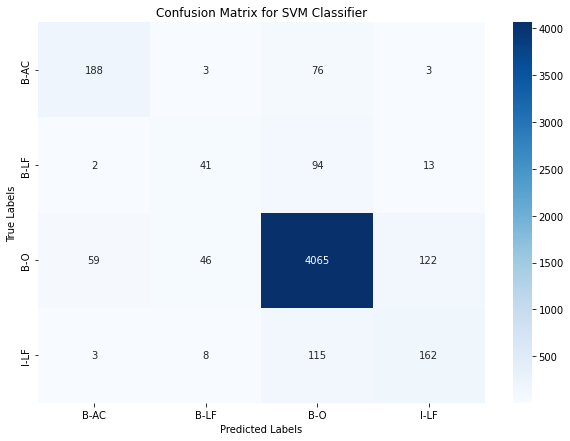

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_flat, y_pred, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

# Experiment 3: SVM with different tokenizer

## SVM using TfidfVectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Flatten the dataset tokens and tags
def flatten_dataset(data):
    tokens = [token for sent in data['tokens'] for token in sent]
    tags = [tag for sent in data['ner_tags'] for tag in sent]
    return tokens, tags

train_tokens, train_tags = flatten_dataset(train_data)
test_tokens, test_tags = flatten_dataset(test_data)

# Initialize label encoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_tags)
test_labels = label_encoder.transform(test_tags)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', token_pattern=r'\b\w+\b', max_features=5000)

# SVM classifier pipeline
svm_pipeline = make_pipeline(tfidf_vectorizer, SVC(kernel='linear', C=1.0, random_state=42))

In [20]:
# Train the SVM classifier
svm_pipeline.fit(train_tokens, train_labels)

# Predict on the test set
predicted_labels = svm_pipeline.predict(test_tokens)

# Convert integer labels back to original string labels
predicted_tags = label_encoder.inverse_transform(predicted_labels)
test_tags = [label_encoder.classes_[label] for label in test_labels]

# Calculate and print Weighted F1 Score
weighted_f1_score = f1_score(test_tags, predicted_tags, average='weighted')
print("Weighted F1 Score on Test Data:", weighted_f1_score)

# Evaluate the classifier
print(classification_report(test_tags, predicted_tags))

Weighted F1 Score on Test Data: 0.8336943365326887
              precision    recall  f1-score   support

        B-AC       0.79      0.23      0.35       270
        B-LF       0.30      0.07      0.12       150
         B-O       0.88      0.98      0.93      4292
        I-LF       0.41      0.20      0.27       288

    accuracy                           0.86      5000
   macro avg       0.60      0.37      0.42      5000
weighted avg       0.83      0.86      0.83      5000



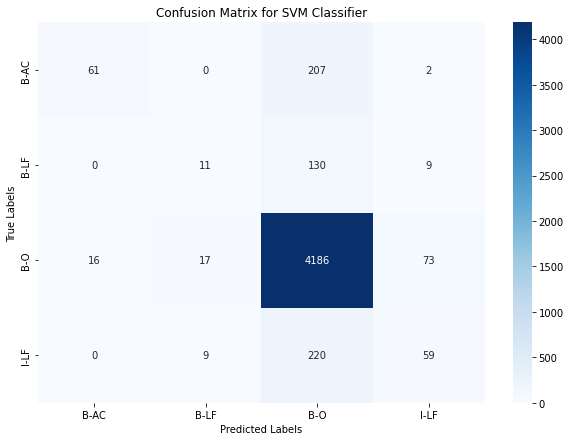

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(test_tags, predicted_tags, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

## SVM using Word2Vec with data blancing

In [26]:
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from datasets import load_dataset
import numpy as np

# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset['train']
test_data = dataset['test']

In [27]:
# Prepare sentences and labels for Word2Vec training and SVM classification
def prepare_sentences_and_labels(data):
    sentences = [sentence for doc in data['tokens'] for sentence in doc]
    labels = [tag for doc in data['ner_tags'] for tag in doc]
    return sentences, labels

train_sentences, train_labels = prepare_sentences_and_labels(train_data)
test_sentences, test_labels = prepare_sentences_and_labels(test_data)

# Train Word2Vec model
model_w2v = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to create sentence vectors by averaging word vectors
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Create sentence embeddings
train_embeddings = np.array([sentence_vector(sentence, model_w2v) for sentence in train_sentences])
test_embeddings = np.array([sentence_vector(sentence, model_w2v) for sentence in test_sentences])

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Resample the training dataset
ros = RandomOverSampler(random_state=42)
train_embeddings_resampled, train_labels_resampled = ros.fit_resample(train_embeddings, train_labels_encoded)

In [28]:
# Show percentage of each class in the resampled data
class_distribution = Counter(train_labels_resampled)
for label, count in class_distribution.items():
    percentage = (count / len(train_labels_resampled)) * 100
    print(f"Class {label_encoder.inverse_transform([label])[0]}: {count} samples ({percentage:.2f}%)")

Class B-O: 32971 samples (25.00%)
Class B-LF: 32971 samples (25.00%)
Class I-LF: 32971 samples (25.00%)
Class B-AC: 32971 samples (25.00%)


In [30]:
# Train SVM on resampled data
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(train_embeddings_resampled, train_labels_resampled)

# Predict on the test set
predicted_labels = svm_classifier.predict(test_embeddings)
predicted_tags = label_encoder.inverse_transform(predicted_labels)

# Evaluate the classifier
print(classification_report(test_labels, predicted_tags))

              precision    recall  f1-score   support

        B-AC       0.53      0.90      0.67       270
        B-LF       0.06      0.65      0.11       150
         B-O       0.98      0.39      0.56      4292
        I-LF       0.10      0.39      0.15       288

    accuracy                           0.42      5000
   macro avg       0.42      0.58      0.37      5000
weighted avg       0.88      0.42      0.53      5000



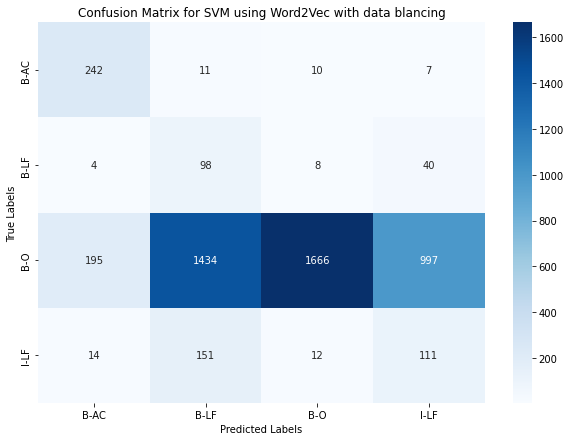

In [31]:
# Calculate the confusion matrix
cm = confusion_matrix(test_tags, predicted_tags, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM using Word2Vec with data blancing')
plt.show()

## SVM using TfidfVectorizer with data-balancing

In [29]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
from imblearn.over_sampling import RandomOverSampler
# Encode the tags
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_tags)
test_labels = label_encoder.transform(test_tags)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', token_pattern=r'\b\w+\b', max_features=5000)
train_features = tfidf_vectorizer.fit_transform(train_tokens)

# Resample the dataset to balance class distribution
ros = RandomOverSampler(random_state=42)
train_resampled_features, train_resampled_labels = ros.fit_resample(train_features, train_labels)

In [31]:
# Show percentage of each class in the resampled data
class_distribution = Counter(train_labels_resampled)
for label, count in class_distribution.items():
    percentage = (count / len(train_labels_resampled)) * 100
    print(f"Class {label_encoder.inverse_transform([label])[0]}: {count} samples ({percentage:.2f}%)")

Class B-O: 32971 samples (25.00%)
Class B-LF: 32971 samples (25.00%)
Class I-LF: 32971 samples (25.00%)
Class B-AC: 32971 samples (25.00%)


In [32]:
# Train the SVM classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(train_resampled_features, train_resampled_labels)

# Vectorize the test data and predict
test_features = tfidf_vectorizer.transform(test_tokens)
predicted_labels = svm_model.predict(test_features)

# Convert integer labels back to original string labels
predicted_tags = label_encoder.inverse_transform(predicted_labels)

# Evaluate the classifier
print(classification_report(test_tags, predicted_tags))

              precision    recall  f1-score   support

        B-AC       0.47      0.29      0.36       270
        B-LF       0.17      0.39      0.24       150
         B-O       0.90      0.80      0.85      4292
        I-LF       0.18      0.44      0.26       288

    accuracy                           0.74      5000
   macro avg       0.43      0.48      0.43      5000
weighted avg       0.82      0.74      0.77      5000



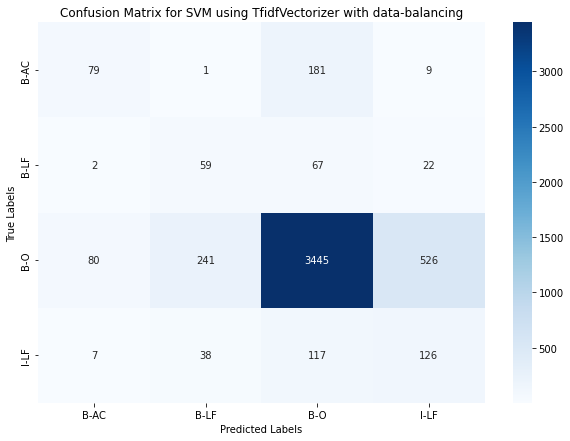

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(test_tags, predicted_tags, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM using TfidfVectorizer with data-balancing')
plt.show()

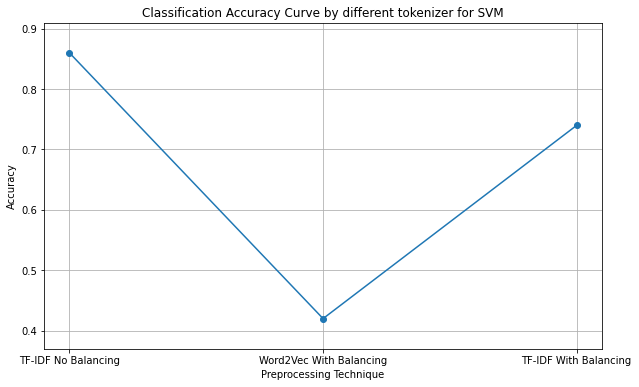

In [34]:
preprocessing_labels = ['TF-IDF No Balancing', 'Word2Vec With Balancing', 'TF-IDF With Balancing']
Accuracy = [0.86, 0.42, 0.74]

# Plotting Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(preprocessing_labels, Accuracy, marker='o')
plt.title('Classification Accuracy Curve by different tokenizer for SVM')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(preprocessing_labels)
plt.ylim([min(Accuracy) - 0.05, max(Accuracy) + 0.05])
plt.show()

# Experiment 4: FNN

## SVM with GridSearchCV

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from datasets import load_dataset

# Load and prepare the data
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset['train']
test_data = dataset['test']

def flatten_dataset(data):
    tokens = [token for sent in data['tokens'] for token in sent]
    tags = [tag for sent in data['ner_tags'] for tag in sent]
    return tokens, tags

train_tokens, train_tags = flatten_dataset(train_data)
test_tokens, test_tags = flatten_dataset(test_data)

# Encode the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_tags)
test_labels = label_encoder.transform(test_tags)

In [36]:
# Define and train the SVM model with GridSearch
tfidf_vectorizer = TfidfVectorizer(lowercase=True, analyzer='word', token_pattern=r'\b\w+\b', max_features=5000)
svm = SVC(kernel='linear', C=1.0, random_state=42)
pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('svm', svm)])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'tfidf__max_features': [5000, 10000],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(train_tokens, train_labels)

# Predict using the best model
predicted_labels = grid_search.predict(test_tokens)

# Inverse transform the predicted labels to original tags for evaluation
predicted_tags = label_encoder.inverse_transform(predicted_labels)

# Evaluate the model
print(classification_report(test_tags, predicted_tags))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
              precision    recall  f1-score   support

        B-AC       0.74      0.30      0.43       270
        B-LF       0.29      0.13      0.18       150
         B-O       0.89      0.97      0.93      4292
        I-LF       0.39      0.21      0.27       288

    accuracy                           0.86      5000
   macro avg       0.58      0.40      0.45      5000
weighted avg       0.83      0.86      0.84      5000



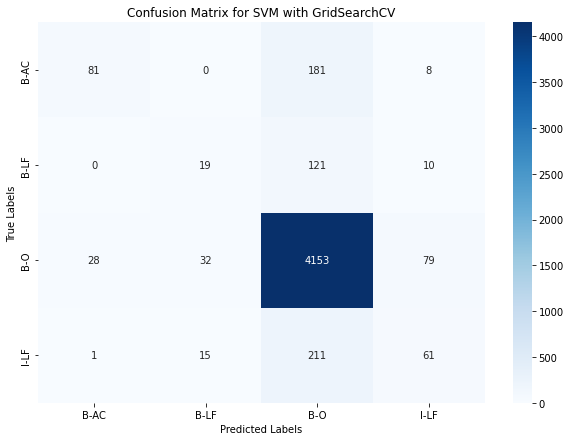

In [37]:
# Calculate the confusion matrix
cm = confusion_matrix(test_tags, predicted_tags, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM with GridSearchCV')
plt.show()

## Using grid search to find the best regularization parameters for CRF

In [38]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score

# Define the parameter grid
c1_values = [0.01, 0.1, 0.5]
c2_values = [0.01, 0.1, 0.5]
best_score = 0
best_params = {}

# Iterate over all parameter combinations
for c1 in c1_values:
    for c2 in c2_values:
        crf = CRF(algorithm='lbfgs', c1=c1, c2=c2, max_iterations=200, all_possible_transitions=True)
        crf.fit(X_train, y_train)
        y_pred = crf.predict(X_test)
        score = flat_f1_score(y_test, y_pred, average='weighted')
        print(f'Tested c1={c1}, c2={c2}, F1 Score: {score}')

        # Check for a new best score
        if score > best_score:
            best_score = score
            best_params = {'c1': c1, 'c2': c2}

print("Best F1 Score:", best_score)
print("Best Parameters:", best_params)

Tested c1=0.01, c2=0.01, F1 Score: 0.9028843129563249
Tested c1=0.01, c2=0.1, F1 Score: 0.9084631043778376
Tested c1=0.01, c2=0.5, F1 Score: 0.9126426766944779
Tested c1=0.1, c2=0.01, F1 Score: 0.9061978283835784
Tested c1=0.1, c2=0.1, F1 Score: 0.9097083044009505
Tested c1=0.1, c2=0.5, F1 Score: 0.9082418746240799
Tested c1=0.5, c2=0.01, F1 Score: 0.9118576250405105
Tested c1=0.5, c2=0.1, F1 Score: 0.9102131805091569
Tested c1=0.5, c2=0.5, F1 Score: 0.9063608335819728
Best F1 Score: 0.9126426766944779
Best Parameters: {'c1': 0.01, 'c2': 0.5}


### Apply CRF with Best Parameters

In [39]:
# Preprocessing function to apply
train_sentences = [preprocess_no_change(sentence) for sentence in train_data['tokens']]  # No preprocessing

# Apply the chosen preprocessing function to the test data
test_sentences = [preprocess_no_change(sentence) for sentence in test_data['tokens']] 

# Each sentence is transformed into a list of (token, tag) tuples.
train_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(train_sentences, train_data['ner_tags'])
]

# Prepare the test data for CRF
test_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(test_sentences, test_data['ner_tags'])
]

# X contain extracted features for each token in each sentence of the training and test datasets.
# Y contain the corresponding NER tags for each token.
# These variables are used to train the CRF model and evaluate its performance on unseen data.
X_train = [extract_features(s) for s in train_sents]
y_train = [extract_labels(s) for s in train_sents]

# Extract features and labels from the test data
X_test = [extract_features(s) for s in test_sents]
y_test = [extract_labels(s) for s in test_sents]

# Extract unique labels from the training data for reporting
unique_labels = sorted(set([label for sublist in y_train for label in sublist]))

# Now continue with the CRF training and evaluation using the test data
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.5, max_iterations=200, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Predict using the trained CRF model on the test data
y_pred_test = crf.predict(X_test)

# Calculate F1 Score and report for the test data
f1_score_test = metrics.flat_f1_score(y_test, y_pred_test, average='weighted')
print("F1 Score on Test Data:", f1_score_test)

# Generate classification report for the test data
y_true_flat_test = [label for sublist in y_test for label in sublist]
y_pred_flat_test = [label for sublist in y_pred_test for label in sublist]
report_test = classification_report(y_true_flat_test, y_pred_flat_test, labels=unique_labels, digits=3)
print("Classification Report on Test Data:\n", report_test)

F1 Score on Test Data: 0.9126426766944779
Classification Report on Test Data:
               precision    recall  f1-score   support

        B-AC      0.800     0.622     0.700       270
        B-LF      0.643     0.480     0.550       150
         B-O      0.940     0.970     0.955      4292
        I-LF      0.720     0.625     0.669       288

    accuracy                          0.917      5000
   macro avg      0.776     0.674     0.718      5000
weighted avg      0.911     0.917     0.913      5000



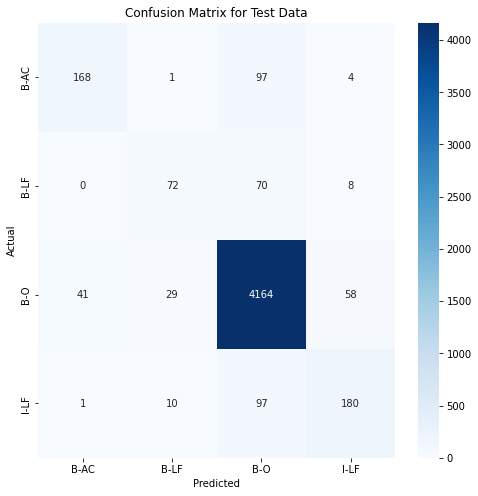

In [40]:
# Confusion Matrix for test data
conf_mat_test = confusion_matrix(y_true_flat_test, y_pred_flat_test, labels=unique_labels)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Data')
plt.show()

## 5-fold crocss-vaildation best parameters for CRF

Average F1 Score: 0.8919799449902651


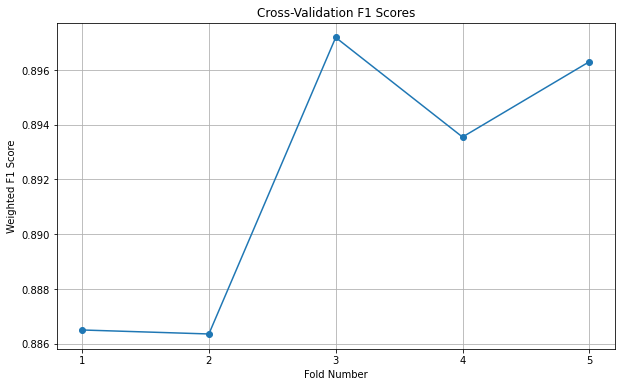

In [49]:
# Combine training and validation sentences and corresponding tags
train_val_sentences = train_data['tokens'] + validation_data['tokens']
train_val_tags = train_data['ner_tags'] + validation_data['ner_tags']

# Transform into sentences of (token, tag) tuples for training and validation
train_val_sents = [
    [(token, tag) for token, tag in zip(sentence, tags)]
    for sentence, tags in zip(train_val_sentences, train_val_tags)
]

# Extract features and labels for training and validation
X_train_val = [extract_features(s) for s in train_val_sents]
y_train_val = [extract_labels(s) for s in train_val_sents]

# Extract features and labels for the test set
X_test = [extract_features(s) for s in test_sents]
y_test = [extract_labels(s) for s in test_sents]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for train_index, val_index in kf.split(X_train_val):
    # Splitting the data for this fold
    X_train, X_val = [X_train_val[i] for i in train_index], [X_train_val[i] for i in val_index]
    y_train, y_val = [y_train_val[i] for i in train_index], [y_train_val[i] for i in val_index]

    # Initialize and train the CRF model
    crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.1, max_iterations=200, all_possible_transitions=True)
    crf.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = crf.predict(X_val)
    
    # Calculate the F1 score for this fold and append to the scores list
    f1 = flat_f1_score(y_val, y_pred, average='weighted')
    f1_scores.append(f1)

# Calculate and print the average F1 Score across all folds
average_f1 = sum(f1_scores) / len(f1_scores)
print("Average F1 Score:", average_f1)

# Plot the Cross-Validation F1 Scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.title('Cross-Validation F1 Scores')
plt.xlabel('Fold Number')
plt.ylabel('Weighted F1 Score')
plt.xticks(range(1, len(f1_scores) + 1))
plt.grid(True)
plt.show()